## NOTE: Please view on nbviewer to see plotly charts. 
nbviewer: https://github.com/connormca12/Springboard-Projects/blob/master/capstone-2/notebooks/data_wrangling_and_eda.ipynb

# Data Wrangling and EDA - Amazon Rainforest Image Classification
Capstone Project 2 - Connor McAnuff


## Contents:
- Module Importing
- Data Importing
- Image Tags Exploration and Visualization
- Image Samples
- Image Histograms and Equalization
- Mean Images and Dominant Colours
- Image Clustering

In [3]:
%load_ext watermark

In [4]:
%watermark -a "Connor McAnuff" -d -t -v -p numpy,pandas

Connor McAnuff 2019-11-14 11:47:30 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.4
pandas 0.24.2


In [5]:
# Auto reload modules marked with "%aimport"
# Use a line %aimport [module to be imported]
%load_ext autoreload
%autoreload 1

## Module Importing

In [6]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter, defaultdict

import cv2
from tqdm import tqdm_notebook as tqdm
import pickle

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

PROJ_ROOT = os.path.join(os.pardir)

print(os.path.abspath(PROJ_ROOT))

C:\Users\conno\Documents\Springboard\Projects\Springboard-Projects\capstone-2


## Data Importing

In [7]:
# Get the file/directory sizes
print('# File sizes')
for f in os.listdir(PROJ_ROOT + '/data/raw/'):
    if not os.path.isdir(PROJ_ROOT + '/data/raw/' + f):
        print(f.ljust(30) + str(round(os.path.getsize(PROJ_ROOT + '/data/raw/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize(PROJ_ROOT + '/data/raw/'+f+'/'+x)/1000000 for x in os.listdir(PROJ_ROOT + '/data/raw/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
.gitkeep                      0.0MB
test_v2_file_mapping.csv      0.61MB
train-jpg                     634.68MB (40479 files)
train-jpg.zip                 637.16MB
train-tif-v2                  21234.96MB (40479 files)
train-tif-v2.tar              21264.11MB
train_v2.csv                  1.43MB


In [8]:
# Set paths to data

jpg_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-jpg')
                            + '\\{}' + '.jpg')

tif_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-tif-v2')
                            + '\\{}' + '.tif')

image_tags_path = os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train_v2.csv')

output_data_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'processed')
                             + '\\{}')

output_figure_path = str(os.path.join(PROJ_ROOT,
                            'reports',
                            'figures')
                             + '\\{}')

## Image Tags Exploration and Visualization
Partially adapted from: https://www.kaggle.com/anokas/data-exploration-analysis

In [9]:
# Train_v2.csv is an array containing a list of the images and their tags
df = pd.read_csv(image_tags_path)
print('Total of {} images'.format(len(df)))
df.head()

Total of 40479 images


image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [10]:
# Create a series of tags, each observation split into multiple strings
tags = df['tags'].apply(lambda x: x.split(' '))

# Create a list of all occuring, non-unique tags
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]

all_tags[:10]

['haze',
 'primary',
 'agriculture',
 'clear',
 'primary',
 'water',
 'clear',
 'primary',
 'clear',
 'primary']

In [11]:
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of tags per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 116278 non-unique tags in all training images
average number of tags per image 2.8725511993873365


In [12]:
# Calculate the number of occurences of each tag 
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False).reset_index(drop=True)
tags_counted_and_sorted.columns = ['tag', 'count']

tags_counted_and_sorted.to_csv(output_data_path.format('tags_count.csv'))

tags_counted_and_sorted

tag  count
0             primary  37513
1               clear  28431
2         agriculture  12315
3                road   8071
4               water   7411
5       partly_cloudy   7261
6         cultivation   4547
7          habitation   3660
8                haze   2697
9              cloudy   2089
10        bare_ground    862
11  selective_logging    340
12     artisinal_mine    339
13           blooming    332
14         slash_burn    209
15          blow_down    101
16  conventional_mine    100

In [13]:
# Use a defaultdict to pass information to plotly

counts = defaultdict(int)
for l in tags:
    for l2 in l:
        counts[l2] += 1

data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=600, width=1000, xaxis_title='Tag', yaxis_title='Count', font=dict(size=15, color='black'))
fig=dict(data=data, layout=layout)
fig = go.Figure(fig)
fig.show()
fig.write_image(output_figure_path.format('tags_count.png'))

- Almost all images are tagged with primary
- The assumed most important tags have very few occurences compared to other tags:
    - slash_burn (209)
    - artisinal_mine (339)
    - selective_logging (340)
    - blow_down (101)

In [14]:
# Co-occurence Matrix
com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in tags.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=600, width=1000, font=dict(size=15, color='black'))
fig=dict(data=data, layout=layout)
fig = go.Figure(fig)
fig.show()
fig.write_image(output_figure_path.format('tags_cooccurence.png'))

For each tag on the y-axis, the co-occurence matrix gives the fraction of images with that tag that also have each tag on the x-axis. For example, images tagged with blow_down are also tagged with haze 0% of the time, are also tagged with primary 100% of the time, and are also tagged with agriculture 22.4% of the time. 

- Most tags have a 1.0 or near 1.0 co-occurence value with primary
- cloudy has a 0.0 co-occurence value with all other tags

# Image Samples

The images are given in both jpeg and tiff format. The jpeg images were converted from the tiff images and therefore some sort of loss of detail / accuracy is expected. The tiff images include 4 channels - Red, Green, Blue, and Near-Infrared. They therefore cannot be viewed to see true colour unless the near-infrared channel is removed. 

In [15]:
# Function to fetch the tags of an image
def get_tags(img):
    
    tags = df[df['image_name'] == img]['tags'].values
    
    return tags[0]

In [42]:
# Function to fetch a tif or jpg image given its name
def get_image(name, form):
    """Use opencv to read and return an image given its name and form.
    tag must by in string format e.g. 'train_0' and form must be 'jpg' or 'tif'."""
    
    # If jpg, read in
    if form == 'jpg':
        img = cv2.imread(jpg_image_path.format(name))
        
    # If tif, read in using cv2 flag IMREAD_UNCHANGED    
    elif form == 'tif':
        img = cv2.imread(tif_image_path.format(name), flags=cv2.IMREAD_UNCHANGED)
        
    # Otherwise, print message    
    else:
        print('Image format must be jpg or tif')
    
    return img

# Function to show an image
def show_image(img, *caption):
    """Plot an image. If image is a jpg, a regular image is plotted.
    If image is a tif, the intensity of RGB and Near-Infrared are plotted separately.
    The tif images are therefore not showing true color, rather intensity of each channel."""
    
    # If image is a jpg, plot using imshow after converting BGR to RGB
    if img.shape == (256,256,3):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        for caption in caption:
            plt.annotate(caption, xy=(3,248), color='w')
        
    # Else, if image is a tif, plot the intensity of 4 channels separately
    elif img.shape == (256,256,4):
        
        channels = cv2.split(img)
        
        f, ax = plt.subplots(1,4, figsize=(18,4))
        
        ax[0].imshow(channels[0], cmap='nipy_spectral')
        ax[1].imshow(channels[1], cmap='nipy_spectral')
        ax[2].imshow(channels[2], cmap='nipy_spectral')
        ax[3].imshow(channels[3], cmap='nipy_spectral')
        
        ax[0].set_title('Blue Intensity')
        ax[1].set_title('Green Intensity')
        ax[2].set_title('Red Intensity')
        ax[3].set_title('Near Infrared Intensity')
    
    # Otherwise, print this message
    else:
        print('Please input a valid jpg or tif image')
    
    plt.show()

jpeg image train_10


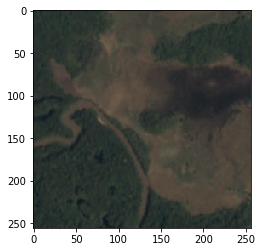

Tags: agriculture clear primary slash_burn water
tif image channel intensities train_10


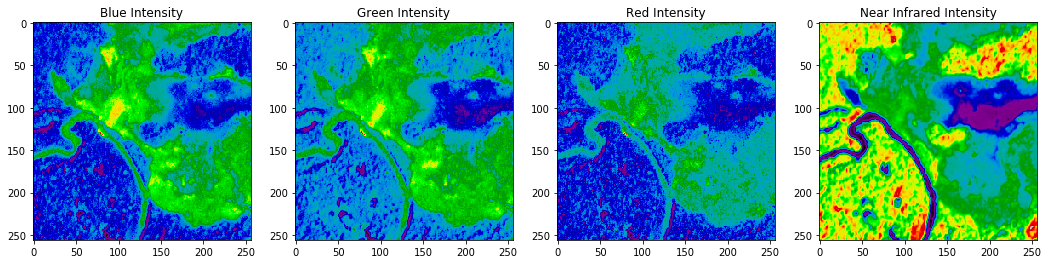

In [45]:
print('jpeg image train_10')
show_image(get_image('train_10', 'jpg'))
print('Tags: ' + get_tags('train_10'))
print('tif image channel intensities train_10')
show_image(get_image('train_10', 'tif'))

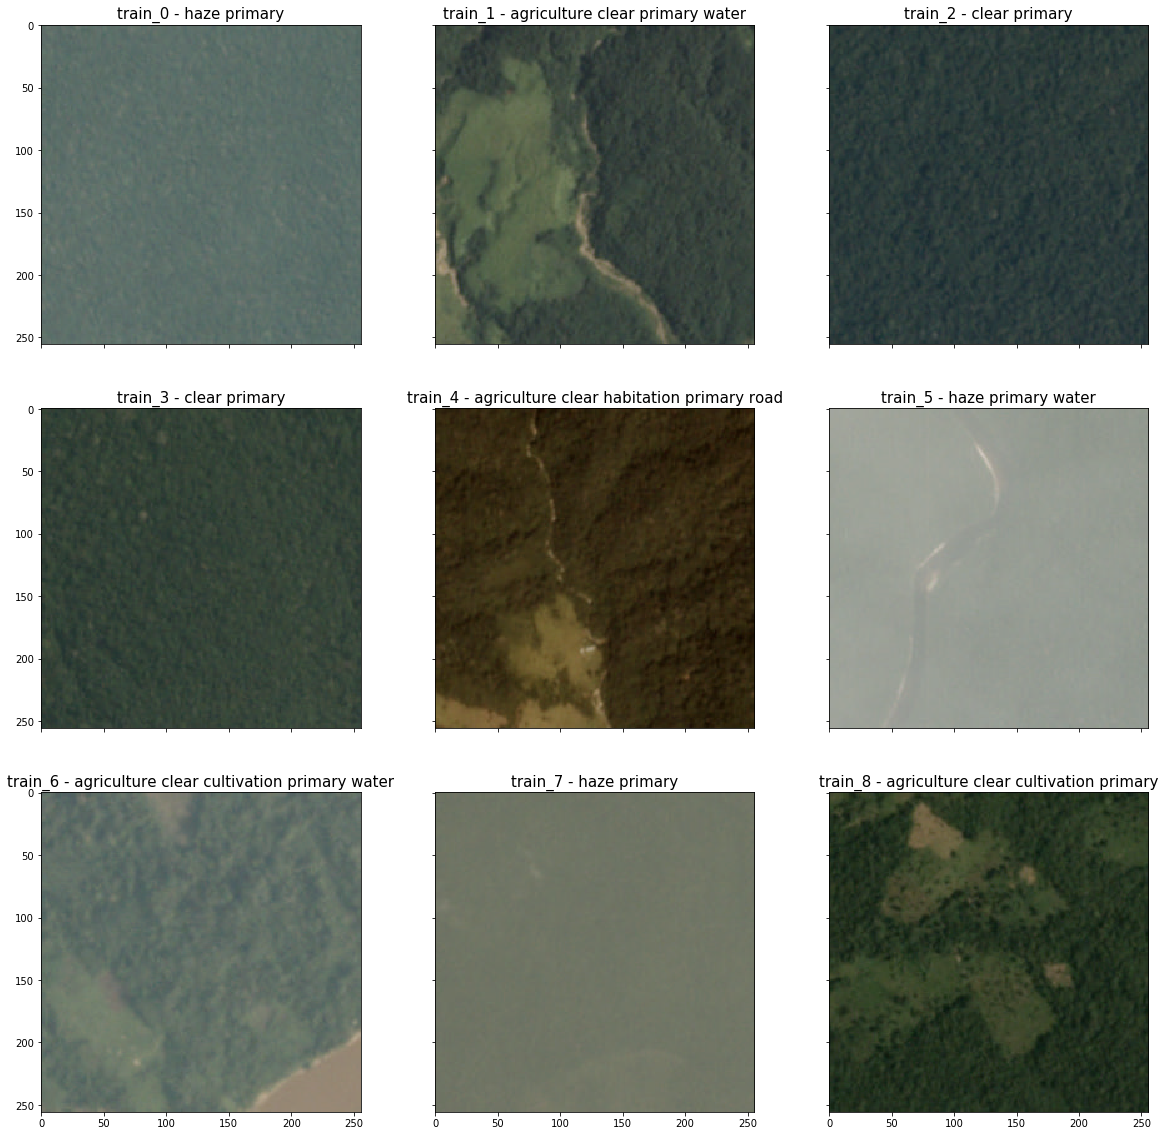

In [18]:
# Plot 9 images for viewing

new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

i = 0
for f, l in df[:9].values:
    
    img = cv2.imread(jpg_image_path.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l), fontsize=15)
    i += 1
    
plt.show()

In [48]:
# Function for viewing images with an input tag
def see_images_by_tag(tag, num_images):

    if tag == 'cloudy':
        images = df[df['tags'].str.contains(tag)]
        images = images[~images['tags'].str.contains('partly_cloudy')]
        
    else:
        images = df[df['tags'].str.contains(tag)]
    
    for image in images['image_name'][:num_images]:
        show_image(get_image(image, 'jpg'), image)

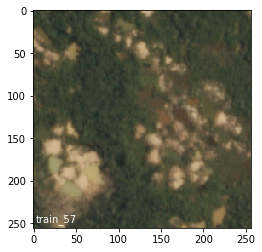

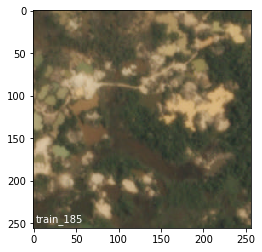

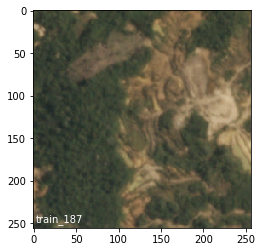

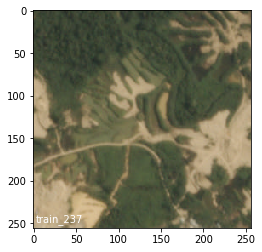

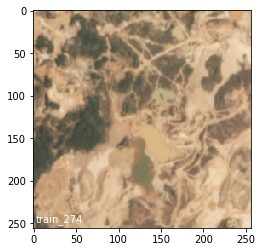

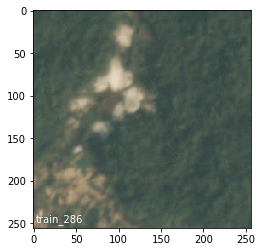

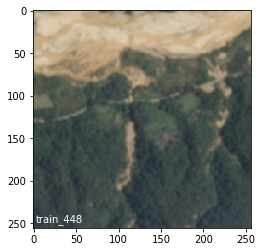

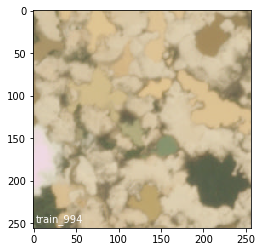

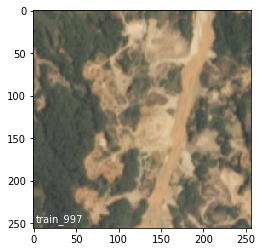

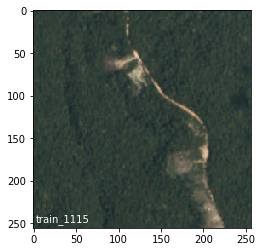

In [49]:
see_images_by_tag('artisinal_mine', 10)

# Image histograms and equalization

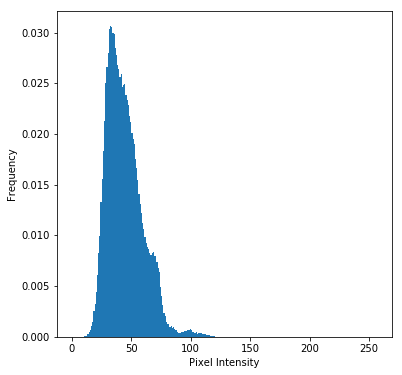

In [21]:
# Plot the pixel intensity of image train_8 
f, ax = plt.subplots(figsize=(6,6))

plt.hist(get_image('train_8', 'jpg').flatten(), bins=256, range=(0, 256), density=True)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Function for rescaling an image (equalization)
def rescale_image(image):
    
    minval, maxval = image.min(), image.max()
    rescaled_image = (255/(maxval - minval) * (image - minval))

    return np.round(rescaled_image).astype('uint8')

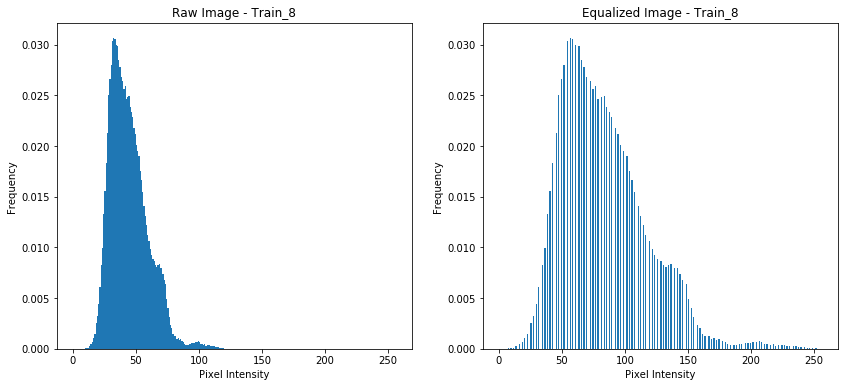

In [24]:
# Plot raw and equalized pixel intensity histograms
f, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(get_image('train_8', 'jpg').flatten(), bins=256, range=(0, 256), density=True)
ax[1].hist(rescale_image(get_image('train_8', 'jpg')).flatten(), bins=256, range=(0, 256), density=True)

ax[0].set_xlabel('Pixel Intensity')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Raw Image - Train_8')

ax[1].set_xlabel('Pixel Intensity')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Equalized Image - Train_8')

plt.show()

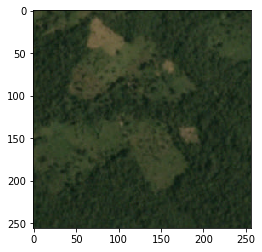

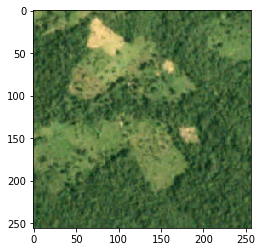

In [25]:
# compare raw and equalized image
show_image(get_image('train_8', 'jpg'))
show_image(rescale_image(get_image('train_8', 'jpg')))

# Mean Images

### Colours within an image
Resource: https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv

In [26]:
# function to calculate the mean colour of a single image
def single_image_mean(image):
    
    single_image = get_image(image, 'jpg')
    single_image_mean = single_image.mean(axis=0).mean(axis=0).round(0).astype('uint8')
    single_image_full = np.ones(shape=single_image.shape, dtype=np.uint8)*single_image_mean
    
    return single_image_full

Original Image


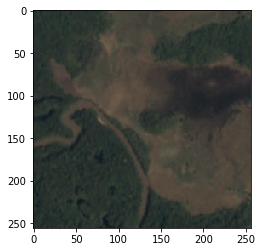

Image Mean Colour


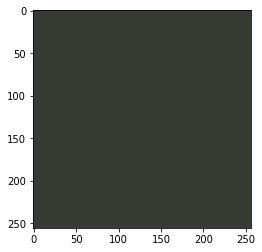

In [27]:
train_10_mean = single_image_mean('train_10')
print('Original Image')
show_image(get_image('train_10', 'jpg'))
print('Image Mean Colour')
show_image(train_10_mean, 'dickballs')

In [28]:
# Function to calculate the mean RGB of each pixel for a set of images
def calc_image_mean(images_list):
    """Input a list of images (list or pandas series form) and return
    the mean RGB value for each pixel location (average R-G-B = total R-G-B / # of images)."""
    
    # Initialize mean image with zeros
    mean_image = np.zeros((256, 256, 3))
    
    # For each image in the image list, get the image and add it to mean image
    for image in images_list:
        mean_image = mean_image + get_image(image, 'jpg')
    
    # Divide the mean image by the number of images
    mean_image = mean_image / len(images_list)
    
    # Return the mean image with values rounded and converted to integers
    return np.round(mean_image).astype('uint8')

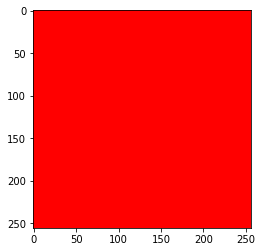

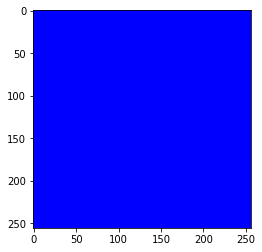

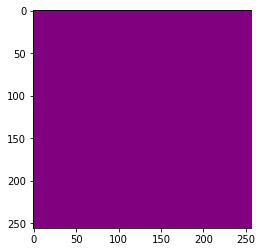

In [51]:
# Testing image set mean function by combining red and blue image to get a purple image
red_image = np.zeros((256, 256, 3))

for row in red_image:
    for column in row:
        column[2] = 255

blue_image = np.zeros((256, 256, 3))

for row in blue_image:
    for column in row:
        column[0] = 255

red_image = np.round(red_image).astype('uint8')
blue_image = np.round(blue_image).astype('uint8')

show_image(red_image)      
show_image(blue_image)

# Initialize mean image with zeros
mean_image_test = np.zeros((256, 256, 3))
images_list = [red_image, blue_image]

# For each image in the image list, get the image and add it to mean image
for image in images_list:
    mean_image_test = mean_image_test + image
    
# Divide the mean image by the number of images
mean_image_test = mean_image_test / len(images_list)
    
# Return the mean image with values rounded and converted to integers
show_image(np.round(mean_image_test).astype('uint8'))

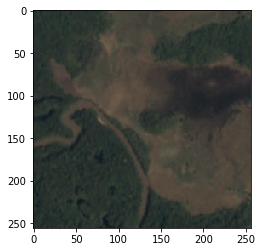

In [31]:
# Testing the image mean function by inputting a single image
mean_image_test = calc_image_mean(df['image_name'].iloc[10:11])
#import pdb; pdb.set_trace()
show_image(mean_image_test)
plt.show()

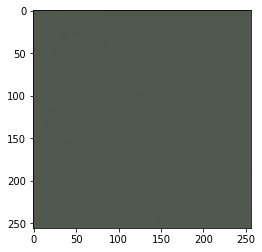

In [32]:
# Calculate the mean image for all images
mean_image_all = calc_image_mean(df['image_name'])
show_image(mean_image_all)

In [33]:
# Calculate the mean image for each tag

mean_image_dict = {}

for tag in tqdm(tags_counted_and_sorted['tag']):

    images_list = df[df['tags'].str.contains(tag)]['image_name']
    
    if tag == 'cloudy':
        images_list = df[df['tags'].str.contains(tag)]
        images_list = images_list[~images_list['tags'].str.contains('partly_cloudy')]['image_name']
    
    print(tag)
    print(len(images_list))
    
    mean_image = calc_image_mean(images_list)
        
    mean_image_dict['mean_image_' + str(tag)] = mean_image

primary
37513
clear
28431
agriculture
12315
road
8071
water
7411
partly_cloudy
7261
cultivation
4477
habitation
3660
haze
2697
cloudy
2089
bare_ground
862
selective_logging
340
artisinal_mine
339
blooming
332
slash_burn
209
blow_down
98
conventional_mine
100



In [34]:
# Save the mean_image_dict for later so process does not need to be re-run 
pickle_out = open(PROJ_ROOT + '/data/processed/mean_image_dict.pkl',"wb")
pickle.dump(mean_image_dict,pickle_out)
pickle_out.close()

In [35]:
# loading from pickle file
pickle_in = open(PROJ_ROOT + '/data/processed/mean_image_dict.pkl',"rb")
mean_image_dict_pkl = pickle.load(pickle_in)

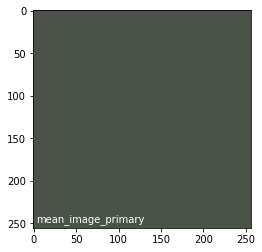

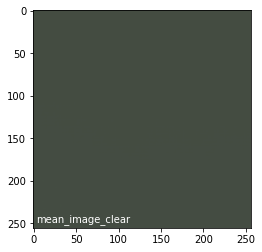

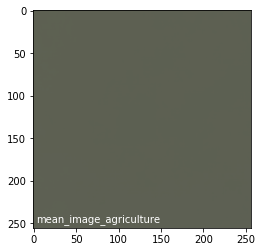

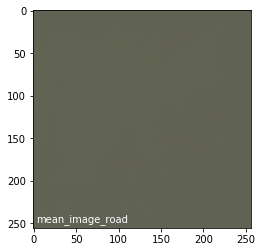

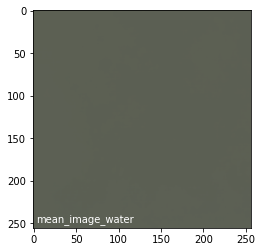

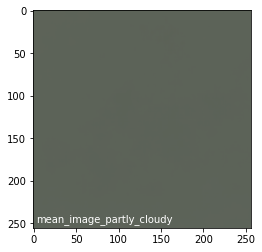

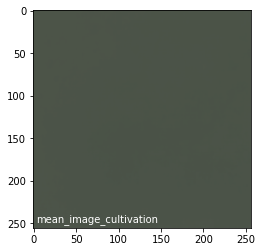

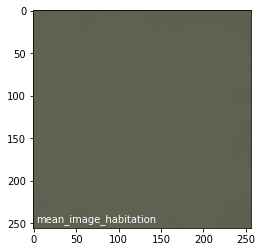

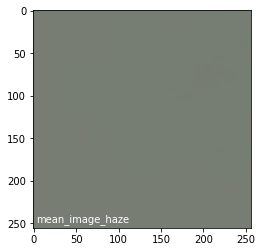

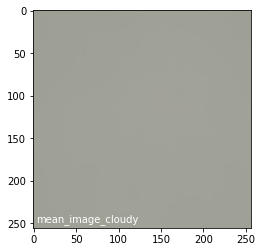

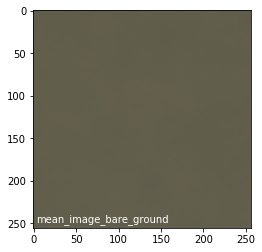

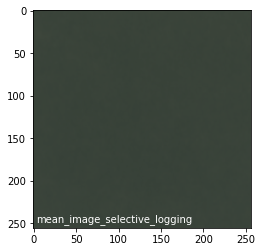

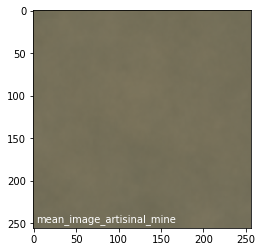

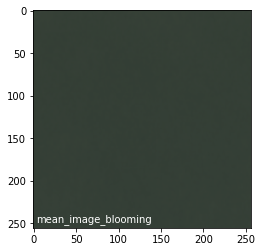

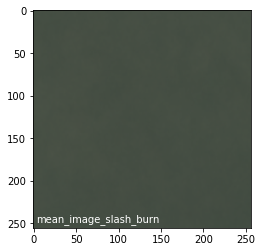

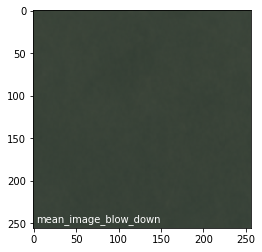

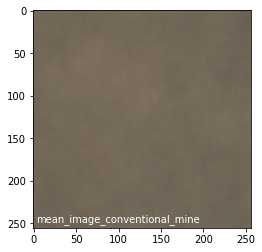

In [36]:
# plot each mean image by tag
for key, value in mean_image_dict.items():
    plt.imshow(cv2.cvtColor(value, cv2.COLOR_BGR2RGB))
    plt.annotate(key, xy=(3,248), color='w')
    plt.show()

### Calculate dominant colours in single image

In [52]:
def get_dominant_colors(image, n_colors=5):

    pixels = np.float32(image.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
    rows = np.int_(img.shape[0]*freqs)

    dominant_pallete_image = np.zeros(shape=image.shape)
    for i in range(len(rows) - 1):
        dominant_pallete_image[rows[i]:rows[i + 1], :, :] += palette[indices[i]]

    return dominant_pallete_image.round(0).astype('uint8')


Original Image


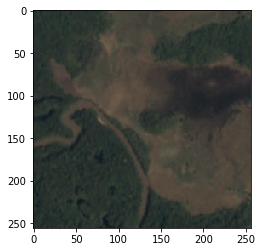

Dominant colours


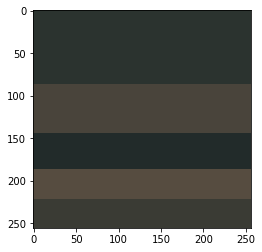

In [53]:
train_10_dom_colors = get_dominant_colors(get_image('train_10', 'jpg'), n_colors=5)
print('Original Image')
show_image(get_image('train_10', 'jpg'))
print('Dominant colours')
show_image(train_10_dom_colors)


In [54]:
def convert_to_dominant_colors(image, n_colors):

    pixels = np.float32(image.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    square_labels = labels.reshape(256,256,1)
    
    dominant_color_convert = np.zeros((256, 256, 3))

    for row in range(256):
        for column in range(256):
            dominant_color_convert[row][column] = palette[square_labels[row][column][0]]

    dominant_color_convert = dominant_color_convert.round(0).astype('uint8')
    
    return dominant_color_convert

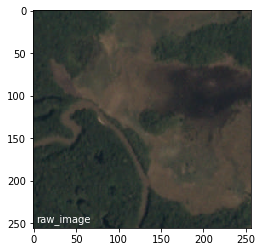

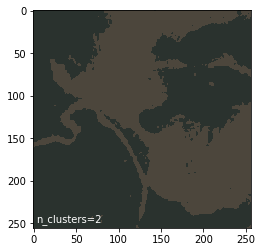

In [60]:
show_image(get_image('train_10', 'jpg'), 'raw_image')
show_image(convert_to_dominant_colors(get_image('train_10', 'jpg'), n_colors=2), 'n_clusters=2')

## Clustering

In [225]:
# Function to get the image matrix for all images 
def get_images_mat(image_names):

    all_imgs = []

    for image_name in tqdm(image_names):
        img = get_image(image_name, 'jpg')
        img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
        img = img.reshape(1, -1)
        all_imgs.append(img)

    img_mat = np.vstack(all_imgs)

    return img_mat

In [226]:
# function to plot images as a scatterplot using the tsne coordinates
def imscatter(tsne, images_list, ax=None, zoom=0.2):
    
    assert len(tsne) == len(images_list)
    
    n_imgs=len(tsne)
    
    x = tsne[0:n_imgs,0]
    y = tsne[0:n_imgs,1]
    images = [get_image(images_list.iloc[i], 'jpg') for i in range(n_imgs)]
    
    plt.figure(figsize=(20,20))
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [33]:
# perform tsne for 1000 random images
all_images_sample = df.sample(1000, random_state=42)
img_mat = get_images_mat(all_images_sample['image_name'])

tsne = TSNE(
    n_components=2,
    perplexity=30,
    init='random', # pca?
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    learning_rate=200,
    verbose=1
).fit_transform(img_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 18.290s...
[t-SNE] Computed neighbors for 1000 samples in 365.193s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 22.344650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.479019
[t-SNE] KL divergence after 1000 iterations: 1.310345


In [39]:
# Save the tsne for later so process does not need to be re-run 
pickle_out = open(PROJ_ROOT + "/data/processed/tsne_1000_samples.pkl","wb")
pickle.dump(tsne,pickle_out)
pickle_out.close()

In [40]:
# Test loading from pickle file
pickle_in = open(PROJ_ROOT + "/data/processed/tsne_1000_samples.pkl","rb")
tsne_1000_samples_pkl = pickle.load(pickle_in)

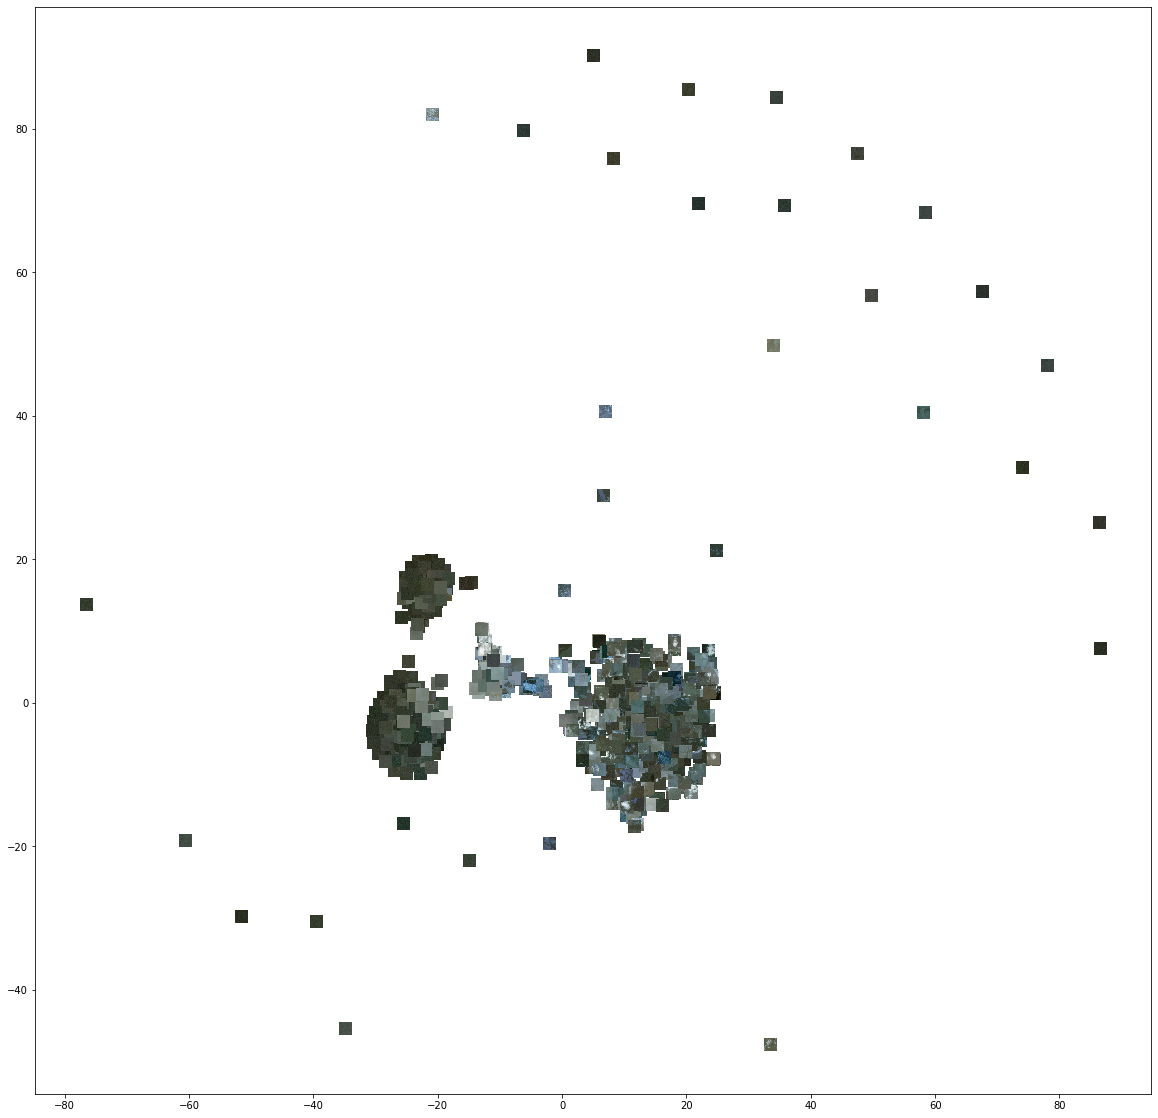

In [44]:
imscatter(tsne=tsne, images_list=all_images_sample['image_name'], zoom=0.05)

In [123]:
# function to get an image list by tag
def get_image_list_by_tag(images, *tags):
    
    for tag in tqdm(tags):
    
        images_list = df[df['tags'].str.contains(tag)]['image_name']
    
        if tag == 'cloudy':
            images_list = df[df['tags'].str.contains(tag)]
            images_list = images_list[~images_list['tags'].str.contains('partly_cloudy')]['image_name']
        
    #image_list_df = df.image_name[[images_list]]

    return images_list

In [124]:
# create a list of images with the 7 most rare tags
rare_tag_image_list = pd.Series()

for tag in tqdm(tags_counted_and_sorted['tag'][-7:]):
    
    temp_images_list = get_image_list_by_tag(df['image_name'], tag)
    
    rare_tag_image_list = rare_tag_image_list.append(temp_images_list)

In [243]:
# perform tsne for images with 7 most rare tags
img_mat_select = get_images_mat(rare_tag_image_list)

tsne_select = TSNE(
    n_components=2,
    perplexity=30,
    init='random', # pca?
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    learning_rate=200,
    verbose=1
).fit_transform(img_mat_select)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2280 samples in 51.091s...
[t-SNE] Computed neighbors for 2280 samples in 1847.766s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2280
[t-SNE] Computed conditional probabilities for sample 2000 / 2280
[t-SNE] Computed conditional probabilities for sample 2280 / 2280
[t-SNE] Mean sigma: 13.935220
[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.397705
[t-SNE] KL divergence after 1000 iterations: 1.709763


In [244]:
# Save the tsne for later so process does not need to be re-run 
pickle_out = open(PROJ_ROOT + "/data/processed/tsne_rare_samples.pkl","wb")
pickle.dump(tsne_select,pickle_out)
pickle_out.close()

In [245]:
# Test loading from pickle file
pickle_in = open(PROJ_ROOT + "/data/processed/tsne_rare_samples.pkl","rb")
tsne_select = pickle.load(pickle_in)

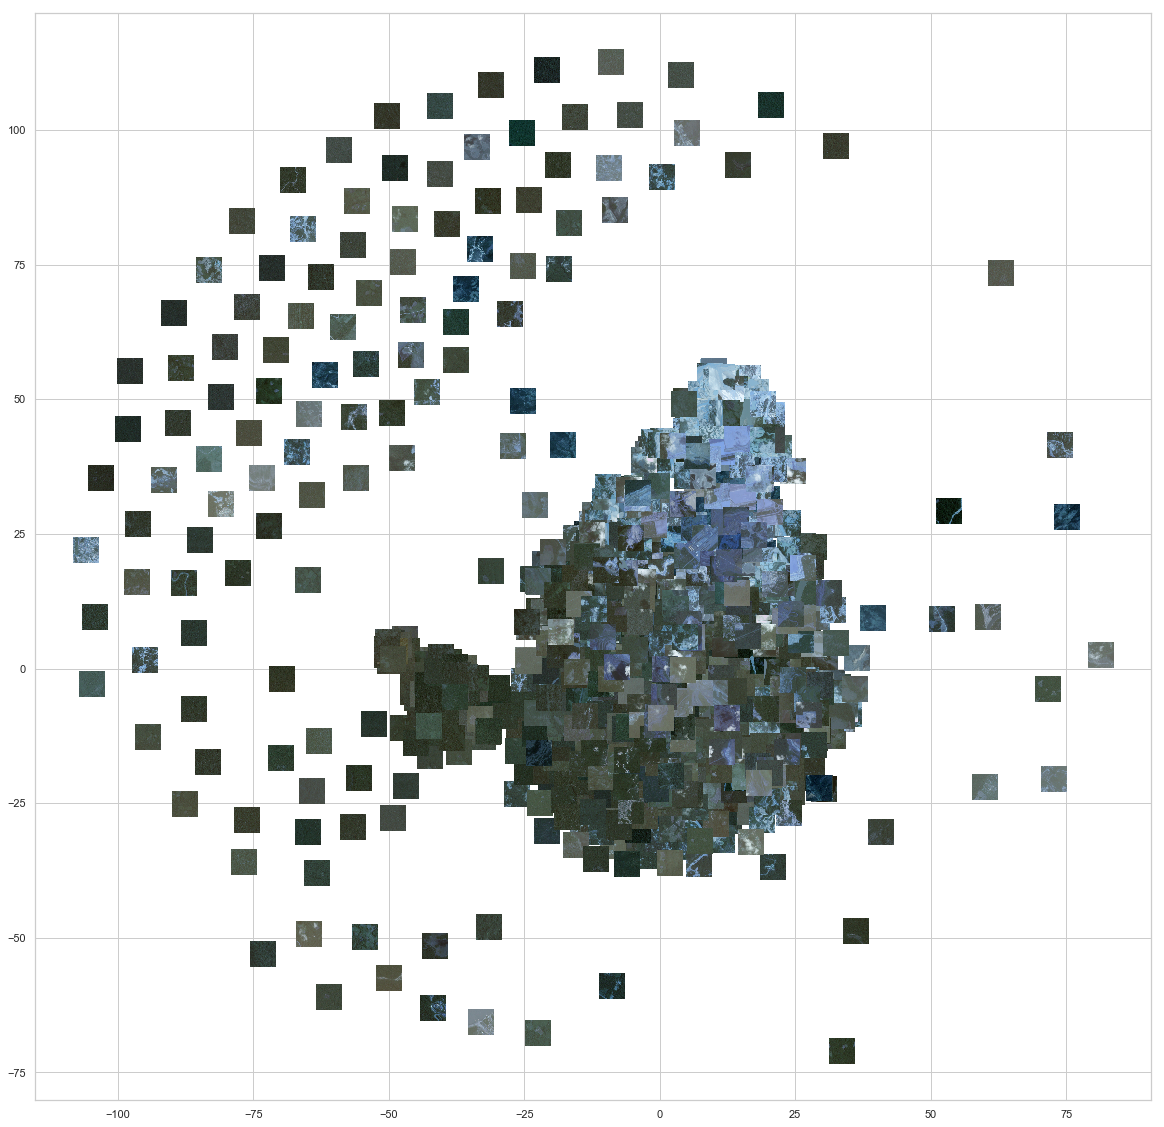

In [358]:
imscatter(tsne=tsne_select, images_list=rare_tag_image_list, zoom=0.1)

In [103]:
# 7 most rare tags
tags_counted_and_sorted['tag'][-7:]

10          bare_ground
11    selective_logging
12       artisinal_mine
13             blooming
14           slash_burn
15            blow_down
16    conventional_mine
Name: tag, dtype: object

In [304]:
# create a rare tag dataframe
rare_tag_image_df = pd.DataFrame({'image_name': rare_tag_image_list,
                                  'tags': [df[df['image_name'] == image]['tags'].values for image in rare_tag_image_list]})

# initiate a rare tag dictionary
rare_tag = {}

# take the rare tag out of the tag column and put into dictionary
for index, row in rare_tag_image_df.iterrows():
    for i, tag in enumerate(tags_counted_and_sorted['tag'][-7:]):
        if tag in row['tags'][0]:
            if tag not in rare_tag:
                rare_tag[row['image_name']] = tag

# map the rare tag dictionary to a new column in the rare_tag_image_df
rare_tag_image_df['rare_tag'] = rare_tag_image_df['image_name'].map(rare_tag)

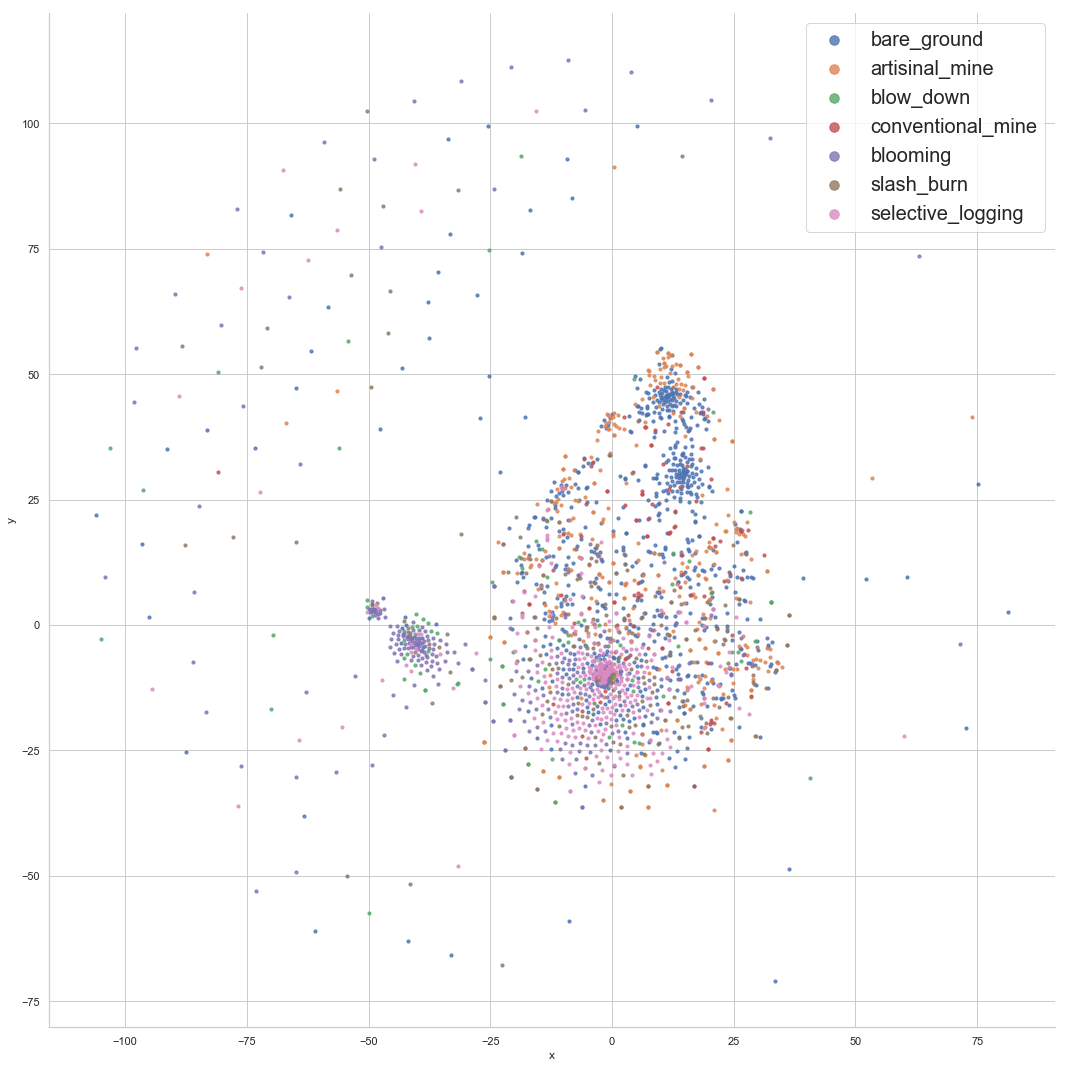

In [357]:
# plot the tsne results and colour the points by rare tag
n_imgs=len(tsne_select)
rare_tag_image_df['x'] = tsne_select[0:n_imgs,0]
rare_tag_image_df['y'] = tsne_select[0:n_imgs,1]
sns.set_style("whitegrid")

sns.lmplot(x='x', y='y', data=rare_tag_image_df, fit_reg=False, hue='rare_tag', height=15, legend_out=False, scatter_kws={"s": 10})
plt.legend(fontsize='20', markerscale=3)

plt.show()

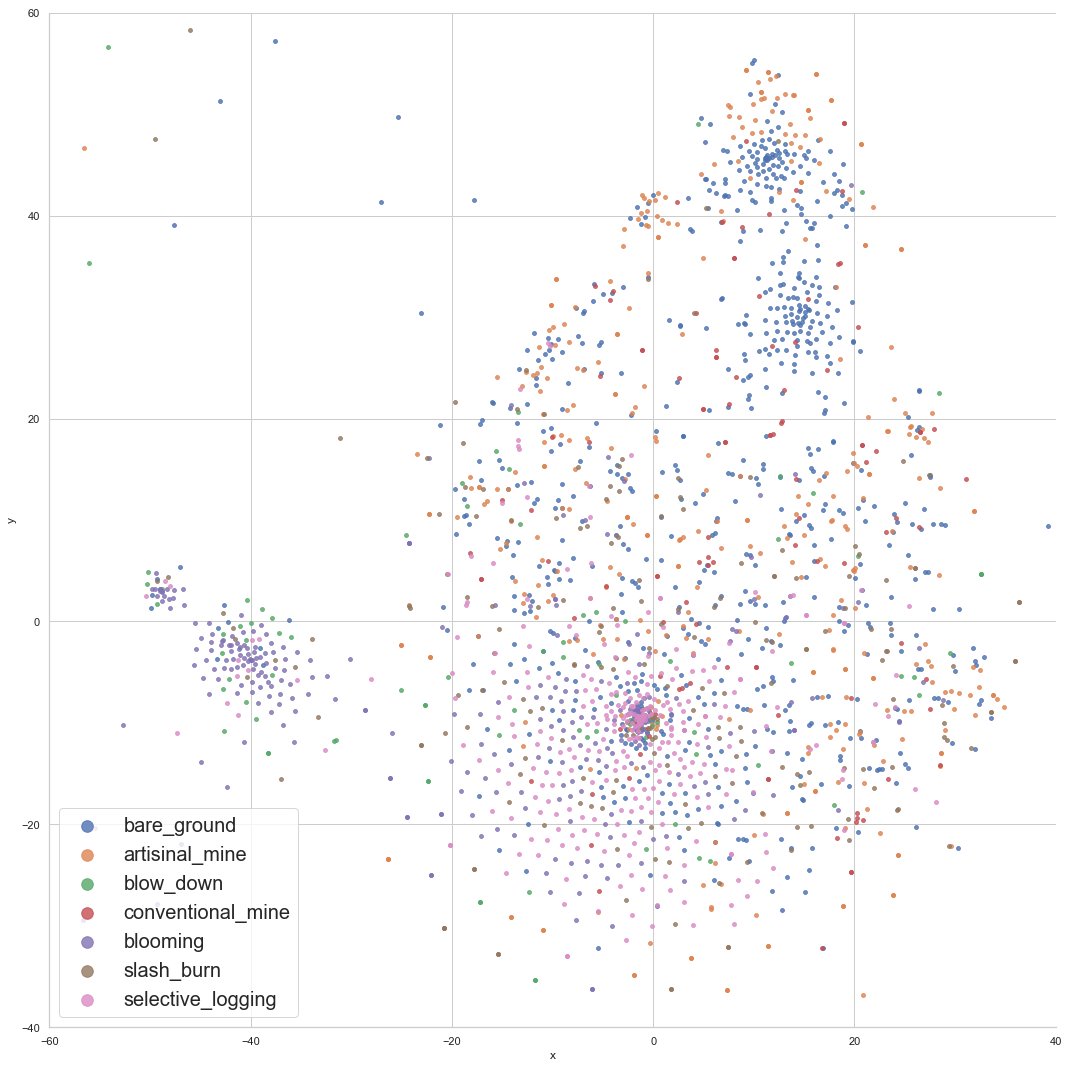

In [355]:
# plot a magnified version of the above plot
n_imgs=len(tsne_select)
rare_tag_image_df['x'] = tsne_select[0:n_imgs,0]
rare_tag_image_df['y'] = tsne_select[0:n_imgs,1]
sns.set_style("whitegrid")

lm = sns.lmplot(x='x', y='y', data=rare_tag_image_df, fit_reg=False, hue='rare_tag', height=15, legend_out=False, scatter_kws={"s": 15})

lm.set(xlim=(-60, 40))
lm.set(ylim=(-40, 60))

plt.legend(fontsize='20', markerscale=3)

plt.show()